### Open the trained models

In [6]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def read_range_files(filenames:list):
    ranges = []
    
    for f in filenames:
        with open(f, 'r') as file:
            ranges.append(file.readlines())
        
    ranges = [float(i.strip()) for row in ranges for i in row]
    ranges = [[ranges[idx], ranges[idx+1]] for idx, i in enumerate(ranges) if idx % 2 == 0]
    
    return ranges


def read_predictor_files(filenames:list):
    
    predictors = []
    for f in predictor_files:
        with open(f, 'rb') as file:
            predictors.append(pickle.load(file))
    return predictors

def predict_on_test_csvs(fpath, bestmodel_container, regressand, target, sample_name=None, print_sample=False, printres=False):
    new_data = pd.read_csv(fpath, 
#                        names=['wavenumber', 'absorbance'], 
                       header=0, # it was reading in the first row as data and causing problems. So I just had it read the column namese from the first row
                       dtype='float')  
    
    # renamed for less typing, but you can absolutely get rid of these column names and just rename to your preference
    new_data = new_data.rename(columns={new_data.columns[0]:'x', new_data.columns[1]:'y'}) 

    # because if you look higher in the code, we are currently regressing on the derivative of the data
    # so I calculated the derivative here
    if regressand == 'a':
        new_data[regressand] = new_data['y']
    if regressand == 'da':
        new_data[regressand] = new_data['y'].diff() 
    elif regressand == 'd2a':
        new_data[regressand] = new_data['y'].diff(order=2)


    # get the wavelength window we care about and slice the data, only keeping that stuff
    window = bestmodel_container[1] 
    new_data = new_data.where(new_data['x'] > window[0]).where(new_data['x'] < window[1]).dropna()
    new_data_dy = np.array(new_data[regressand]).reshape(1,-1)

    predictor = bestmodel_container[0]
    prediction = predictor.predict(new_data_dy)
    
    # discard unwanted nested lists
    for i in prediction.shape:
        prediction = prediction[0] 
        
    if print_sample is True:
        print('Sample: {}'.format(sample_name))
        
    if printres:
        print("predicted composition {} {:1.3f}".format(target, prediction))
    return prediction

In [8]:
predictor_files = ['cellulose_predictor.pkl', 'hemi_predictor.pkl', 'lignin_predictor.pkl']
predictor_files = ['./trained_models/' + p for p in predictor_files]
predictor_metadata_files = [p.split('.pkl')[0] + '_meta.txt' for p in predictor_files] 

ranges = read_range_files(predictor_metadata_files)
predictors = read_predictor_files(predictor_files)
containers = [[j,i] for i, j in zip(ranges, predictors)]
c_container = containers[0]
h_container = containers[1]
l_container = containers[2]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KernelRidge from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
fpaths = [i for i in os.listdir() if ('-' in i and ('.csv' in i or '.CSV' in i))]
c_list, h_list, l_list = [], [], []
sample_names = [i.split('.')[0] for i in fpaths]
regressand = 'da'
for f, n in zip(fpaths, sample_names):
    l = predict_on_test_csvs(f, l_container, regressand, 'lignin', sample_name=n, printres=True, print_sample=True)
    l_list.append(l)
    c = predict_on_test_csvs(f, c_container, regressand, 'cellulose',sample_name=n, printres=True)
    c_list.append(c)
    h = predict_on_test_csvs(f, h_container, regressand, 'hemicellulose',sample_name=n, printres=True)
    h_list.append(h)
    # h_list.append(1 - c - l)



Sample: T2-1
predicted composition lignin 0.466
predicted composition cellulose 0.339
predicted composition hemicellulose 0.119
Sample: T2-3
predicted composition lignin 0.700
predicted composition cellulose 0.173
predicted composition hemicellulose 0.099
Sample: T2-2
predicted composition lignin 0.633
predicted composition cellulose 0.257
predicted composition hemicellulose 0.184
Sample: T6-2
predicted composition lignin -0.223
predicted composition cellulose 0.449
predicted composition hemicellulose 0.014
Sample: T6-3
predicted composition lignin -0.915
predicted composition cellulose 0.076
predicted composition hemicellulose -0.060
Sample: T4-1
predicted composition lignin 0.284
predicted composition cellulose 0.203
predicted composition hemicellulose 0.357
Sample: T4-3
predicted composition lignin 0.496
predicted composition cellulose 0.061
predicted composition hemicellulose 0.472
Sample: T6-1
predicted composition lignin -0.375
predicted composition cellulose 0.410
predicted comp

ValueError: X has 71 features, but KernelRidge is expecting 143 features as input.

There is a problem, though. These do not necessarily sum up to 1. However, presumably we can compare between the model results and test values.

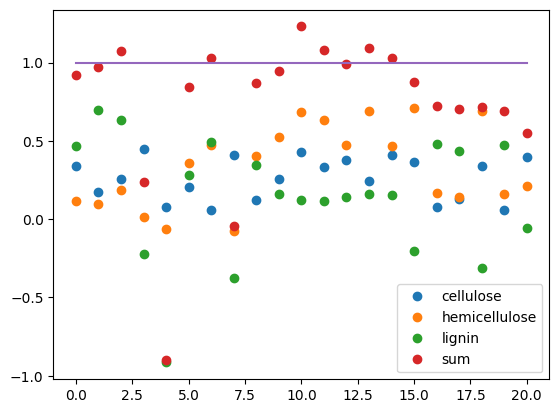

In [10]:
fig, ax = plt.subplots()
xxx = np.arange(len(c_list))
c_list = np.array(c_list)
h_list = np.array(h_list)
l_list = np.array(l_list)
sum_list = c_list + h_list + l_list
ax.plot(xxx, c_list, 'o', label='cellulose')
ax.plot(xxx, h_list, 'o', label = 'hemicellulose')
ax.plot(xxx, l_list, 'o', label = 'lignin')
ax.plot(xxx, sum_list, 'o', label = 'sum')

# for counter, (c, h, l, x) in enumerate(zip(c_list, h_list, l_list,xxx)):
#     if counter == 0:
#         ax.plot(x,c, 'o', color='black', label='cellulose')
#         ax.plot(x, h, 'o', color = 'green', label = 'hemicellulose')
#         ax.plot(x,l, 'o', color='red', label='lignin')
#         ax.plot(x, l + c + h, color = 'orange', label ='sum')



ax.plot(xxx, np.ones_like(xxx))
ax.legend()
